## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve
import re

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import arviz as az
import matplotlib
from matplotlib.font_manager import FontProperties

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

## read data

In [7]:
with open("./data/soccer.csv") as f:
    text=f.readlines()
df=pd.DataFrame(columns=["home_team","away_team","home_score","away_score"])
for term in text:
    term1=term.split("-")[0]
    num1=re.sub("\\D", "", term1)
    country1=term1.replace(num1,"")
    term2=term.split("-")[1]
    num2=re.sub("\\D", "", term2)
    country2=term2.replace(num2,"").replace("\n","")
    
    inserted=pd.Series([country1,country2,int(num1),int(num2)],index=df.columns)
    df=df.append(inserted,ignore_index=True)
df = df.astype({'home_score': int,'away_score': int})

In [8]:
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [9]:
with pm.Model() as model:
    tau_att=pm.Gamma("tau_att",0.1,0.1)
    tau_def=pm.Gamma("tau_def",0.1,0.1)
    home=pm.Flat("home")
    intercept=pm.Flat("intercept")
    
    atts_star=pm.Normal("atts_star",mu=0,tau=tau_att,shape=num_teams)
    defs_star=pm.Normal("defs_star",mu=0,tau=tau_def,shape=num_teams)
    atts=pm.Deterministic("atts",atts_star-tt.mean(atts_star))
    defs=pm.Deterministic("defs",defs_star-tt.mean(defs_star))
    home_theta=tt.exp(intercept+home+atts[home_team]-defs[away_team])
    away_theta=tt.exp(intercept+atts[away_team]-defs[home_team])
    home_points=pm.Poisson("home_points",mu=home_theta,observed=observed_home_goals)
    away_points=pm.Poisson("away_points",mu=away_theta,observed=observed_away_goals)
    
    trace=pm.sample(5000,step=pm.Metropolis(),return_inferencedata=False,cores=1,chains=1)

Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [defs_star]
INFO:pymc3:>Metropolis: [defs_star]
>Metropolis: [atts_star]
INFO:pymc3:>Metropolis: [atts_star]
>Metropolis: [intercept]
INFO:pymc3:>Metropolis: [intercept]
>Metropolis: [home]
INFO:pymc3:>Metropolis: [home]
>Metropolis: [tau_def]
INFO:pymc3:>Metropolis: [tau_def]
>Metropolis: [tau_att]
INFO:pymc3:>Metropolis: [tau_att]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 5 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 5 seconds.
/workspaces/load_to_goal/GitHub/bayesian_statistics/.venv/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (5000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


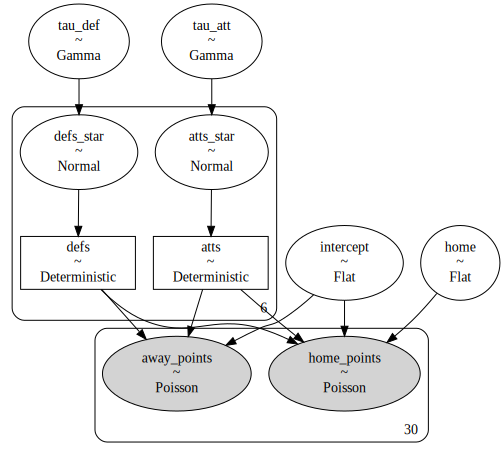

In [10]:
pm.model_to_graphviz(model)

/workspaces/load_to_goal/GitHub/bayesian_statistics/.venv/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (5000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/workspaces/load_to_goal/GitHub/bayesian_statistics/.venv/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (5000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


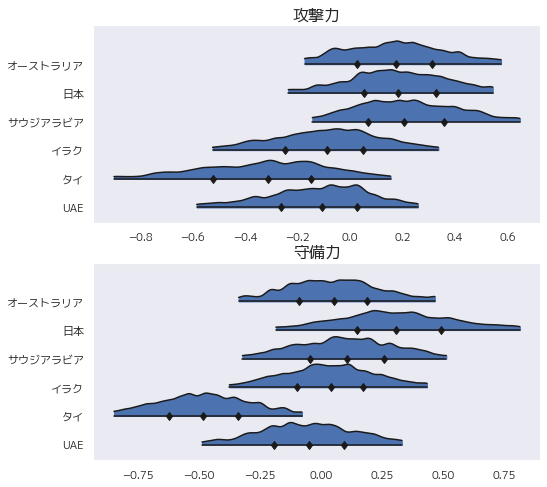

In [11]:
fig,axes=plt.subplots(2,figsize=(8,8))
country_list=list(reversed(["オーストラリア","日本","サウジアラビア","イラク","タイ","UAE"]))
with model:
    az.plot_forest(trace,var_names=["atts"],kind='ridgeplot',ridgeplot_quantiles=[.25, .5, .75],ax=axes[0])
    axes[0].set_title("攻撃力",fontsize=16)
    axes[0].set_yticklabels(country_list)
    az.plot_forest(trace,var_names=["defs"],kind="ridgeplot",ridgeplot_quantiles=[.25, .5, .75],ax=axes[1])
    axes[1].set_title("守備力",fontsize=16)
    axes[1].set_yticklabels(country_list)